In [10]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from keras.layers import Input,Embedding,Bidirectional,LSTM,Dense,Concatenate
from keras.models import Model

In [2]:
df = pd.read_csv("/content/dialogs.txt",names=["question","answer"],sep='\t')
df.head()

,question,answer
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.


In [3]:
print(df.shape)
print("="*60)
print(df.info())
print("="*60)
df.describe()

(3725, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3725 entries, 0 to 3724
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  3725 non-null   object
 1   answer    3725 non-null   object
dtypes: object(2)
memory usage: 58.3+ KB
None


,question,answer
count,3725,3725
unique,3510,3512
top,what do you mean?,what do you mean?
freq,22,22


In [4]:
df.drop_duplicates(subset=['question'],inplace=True)
df.describe()

,question,answer
count,3510,3510
unique,3510,3306
top,"hi, how are you doing?",what do you mean?
freq,1,22


In [5]:
print(df.isnull().sum())
print('\n')
print(df.isnull().any())

question    0
answer      0
dtype: int64


question    False
answer      False
dtype: bool


In [6]:
df.loc[55:60,:]

,question,answer
55,that is true. i hope it doesn't rain.,it wouldn't rain in the middle of the summer.
56,it wouldn't rain in the middle of the summer.,it wouldn't seem right if it started raining r...
57,it wouldn't seem right if it started raining r...,it would be weird if it started raining in nin...
58,it would be weird if it started raining in nin...,any rain right now would be pointless.
59,any rain right now would be pointless.,"that's right, it really would be."
60,"that's right, it really would be.",i want it to cool down some.


In [11]:
stop_words = set(stopwords.words('english'))
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

#remove_stop = True for questions
#remove_stop = False for answers
def preprocess_text(text,remove_stop):
    text = text.lower()
    text = ' '.join([contractions[word] if word in contractions else word for word in text.split()])
    text = re.sub(r'[^a-zA-Z0-9]',' ',text)
    if remove_stop == True:
        text = ' '.join([word for word in text.split() if word not in stop_words])
    text = ' '.join([word for word in text.split()])
    return text

In [12]:
df.question = df.question.apply(preprocess_text,remove_stop=False)
df.answer = df.answer.apply(preprocess_text,remove_stop=False)
df.loc[55:60,:]

,question,answer
55,that is true i hope it does not rain,it would not rain in the middle of the summer
56,it would not rain in the middle of the summer,it would not seem right if it started raining ...
57,it would not seem right if it started raining ...,it would be weird if it started raining in nin...
58,it would be weird if it started raining in nin...,any rain right now would be pointless
59,any rain right now would be pointless,that is right it really would be
60,that is right it really would be,i want it to cool down some


In [13]:
df['decoder_input'] = df.answer.apply(lambda x: 'sos '+x)
df['decoder_label'] = df.answer.apply(lambda x: x+' eo>')
df.head()

,question,answer,decoder_input,decoder_label
0,hi how are you doing,i am fine how about yourself,sos i am fine how about yourself,i am fine how about yourself eo>
1,i am fine how about yourself,i am pretty good thanks for asking,sos i am pretty good thanks for asking,i am pretty good thanks for asking eo>
2,i am pretty good thanks for asking,no problem so how have you been,sos no problem so how have you been,no problem so how have you been eo>
3,no problem so how have you been,i have been great what about you,sos i have been great what about you,i have been great what about you eo>
4,i have been great what about you,i have been good i am in school right now,sos i have been good i am in school right now,i have been good i am in school right now eo>


In [14]:
encoder_input = np.array(df.question)
decoder_input = np.array(df.decoder_input)
decoder_label = np.array(df.decoder_label)

n_rows = df.shape[0]
print(f"{n_rows} rows")

indices = np.arange(n_rows)
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_label = decoder_label[indices]

train_size = 0.9

train_encoder_input = encoder_input[:int(n_rows*train_size)]
train_decoder_input = decoder_input[:int(n_rows*train_size)]
train_decoder_label = decoder_label[:int(n_rows*train_size)]

test_encoder_input = encoder_input[int(n_rows*train_size):]
test_decoder_input = decoder_input[int(n_rows*train_size):]
test_decoder_label = decoder_label[int(n_rows*train_size):]

print(train_encoder_input.shape)
print(train_decoder_input.shape)
print(train_decoder_label.shape)

print(test_encoder_input.shape)
print(test_decoder_input.shape)
print(test_decoder_label.shape)

3510 rows
(3159,)
(3159,)
(3159,)
(351,)
(351,)
(351,)


In [15]:
q_tok = Tokenizer()
q_tok.fit_on_texts(train_encoder_input)
print(len(q_tok.word_counts))

a_tok = Tokenizer()
a_tok.fit_on_texts(train_decoder_input)
a_tok.fit_on_texts(train_decoder_label)
print(len(a_tok.word_counts))

train_encoder_input = q_tok.texts_to_sequences(train_encoder_input)
test_encoder_input = q_tok.texts_to_sequences(test_encoder_input)

train_decoder_input = a_tok.texts_to_sequences(train_decoder_input)
test_decoder_input = a_tok.texts_to_sequences(test_decoder_input)

train_decoder_label = a_tok.texts_to_sequences(train_decoder_label)
test_decoder_label = a_tok.texts_to_sequences(test_decoder_label)

question_word_size = len(q_tok.word_counts)
question_vocab_size = question_word_size+1

answer_word_size = len(a_tok.word_counts)
answer_vocab_size = answer_word_size+1

2241
2243


maximum question sequence length >> 20
maximum answer sequence length >> 21


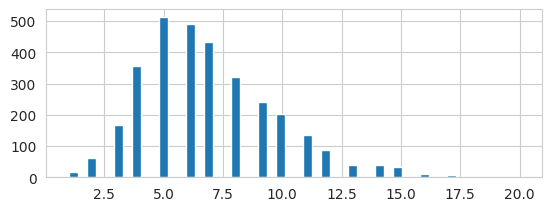

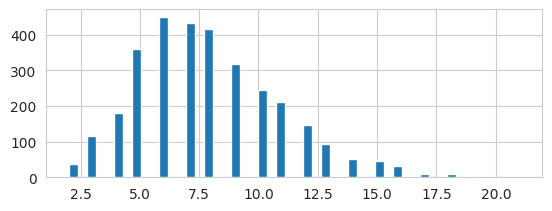

In [16]:
question_lengths = [len(s) for s in train_encoder_input]
print(f"maximum question sequence length >> {np.max(question_lengths)}")

answer_lengths = [len(s) for s in train_decoder_input]
print(f"maximum answer sequence length >> {np.max(answer_lengths)}")

plt.subplot(2,1,1)
plt.hist(question_lengths,bins=50)
plt.show()

plt.subplot(2,1,2)
plt.hist(answer_lengths,bins=50)
plt.show()

In [17]:
train_encoder_input = pad_sequences(train_encoder_input,padding='post')
train_decoder_input = pad_sequences(train_decoder_input,padding='post')
train_decoder_label = pad_sequences(train_decoder_label,padding='post')

print(train_encoder_input.shape)
print(train_decoder_input.shape)
print(train_decoder_label.shape)

question_sequence_size = train_encoder_input.shape[1]
answer_sequence_size = train_decoder_input.shape[1]

test_encoder_input = pad_sequences(test_encoder_input,padding='post',maxlen=question_sequence_size)
test_decoder_input = pad_sequences(test_decoder_input,padding='post',maxlen=answer_sequence_size)
test_decoder_label = pad_sequences(test_decoder_label,padding='post',maxlen=answer_sequence_size)

print(test_encoder_input.shape)
print(test_decoder_input.shape)
print(test_decoder_label.shape)

(3159, 20)
(3159, 21)
(3159, 21)
(351, 20)
(351, 21)
(351, 21)


# Without Attention

In [18]:
import os

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2024-04-19 12:03:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-04-19 12:03:03--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-04-19 12:03:03--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [19]:
#trainer model
embedding_size=256
hidden_size = 256

encoder_input = Input(shape=[question_sequence_size])
# encoder_embedding = Embedding(question_vocab_size,embedding_size,mask_zero=True,trainable=False,weights=[question_embedding_matrix])
encoder_embedding = Embedding(question_vocab_size,embedding_size,mask_zero=True)
encoder_embedded = encoder_embedding(encoder_input)

lstm1 = Bidirectional(LSTM(hidden_size,return_sequences=True,return_state=True,dropout=0.3,recurrent_dropout=0.3))
encoder_output1,_,_,_,_ = lstm1(encoder_embedded)
lstm2 = Bidirectional(LSTM(hidden_size,return_sequences=True,return_state=True,dropout=0.3,recurrent_dropout=0.3))
encoder_output2,_,_,_,_ = lstm2(encoder_output1)
lstm3 = Bidirectional(LSTM(hidden_size,return_sequences=True,return_state=True,dropout=0.3,recurrent_dropout=0.3))
encoder_output3,encoder_forward_h3,encoder_forward_c3,encoder_backward_h3,encoder_backward_c3= lstm3(encoder_output2)

encoder_h3 = Concatenate(axis=-1)([encoder_forward_h3,encoder_backward_h3])
encoder_dense_h = Dense(hidden_size)
encoder_h3 = encoder_dense_h(encoder_h3)

encoder_c3 = Concatenate(axis=-1)([encoder_forward_c3,encoder_backward_c3])
encoder_dense_c = Dense(hidden_size)
encoder_c3 = encoder_dense_c(encoder_c3)

decoder_input = Input(shape=(None,))
# decoder_embedding = Embedding(answer_vocab_size,embedding_size,mask_zero=True,trainable=False,weights=[answer_embedding_matrix])
decoder_embedding = Embedding(answer_vocab_size,embedding_size,mask_zero=True)
decoder_embedded = decoder_embedding(decoder_input)

decoder_lstm = LSTM(hidden_size,return_sequences=True,return_state=True)
decoder_output,_,_ = decoder_lstm(decoder_embedded,initial_state=[encoder_h3,encoder_c3])

dense1 = Dense(512,activation='relu')
decoder_output = dense1(decoder_output)

decoder_softmax = Dense(answer_vocab_size,activation='softmax')
decoder_output = decoder_softmax(decoder_output)

trainer = Model([encoder_input,decoder_input],decoder_output)
trainer.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [21]:
train_hist = trainer.fit([train_encoder_input,train_decoder_input],train_decoder_label,epochs=10,validation_split=0.1,batch_size=32)

Epoch 1/10
89/89 [==============================] - 78s 877ms/step - loss: 4.6126 - accuracy: 0.1988 - val_loss: 4.8540 - val_accuracy: 0.2054
Epoch 2/10
89/89 [==============================] - 71s 803ms/step - loss: 4.3622 - accuracy: 0.2206 - val_loss: 4.8167 - val_accuracy: 0.2162
Epoch 3/10
89/89 [==============================] - 73s 811ms/step - loss: 4.1847 - accuracy: 0.2323 - val_loss: 4.7854 - val_accuracy: 0.2246
Epoch 4/10
89/89 [==============================] - 73s 815ms/step - loss: 4.0354 - accuracy: 0.2443 - val_loss: 4.7877 - val_accuracy: 0.2318
Epoch 5/10
89/89 [==============================] - 64s 709ms/step - loss: 3.8880 - accuracy: 0.2527 - val_loss: 4.8089 - val_accuracy: 0.2290
Epoch 6/10
89/89 [==============================] - 76s 858ms/step - loss: 3.7536 - accuracy: 0.2608 - val_loss: 4.8773 - val_accuracy: 0.2270
Epoch 7/10
89/89 [==============================] - 68s 762ms/step - loss: 3.6153 - accuracy: 0.2676 - val_loss: 4.9449 - val_accuracy: 0.2331

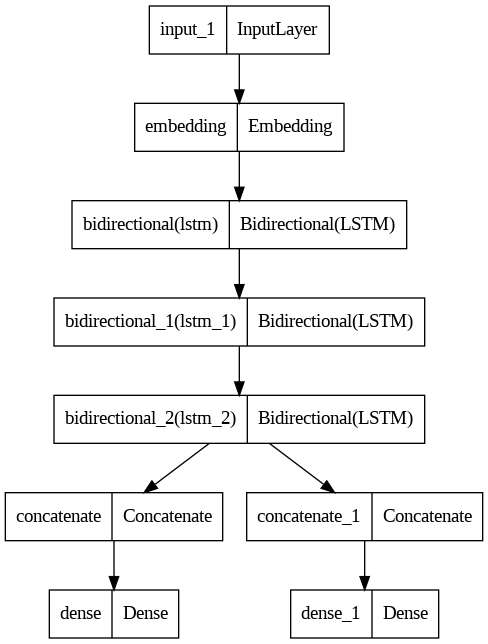

In [22]:
from keras.utils import plot_model

#generator model
gen_encoder = Model(encoder_input,[encoder_h3,encoder_c3])

gen_decoder_h_input = Input(shape=[hidden_size])
gen_decoder_c_input = Input(shape=[hidden_size])

gen_decoder_embedded = decoder_embedding(decoder_input)
gen_decoder_output,gen_decoder_h,gen_decoder_c = decoder_lstm(gen_decoder_embedded,initial_state=[gen_decoder_h_input,gen_decoder_c_input])
gen_decoder_output = dense1(gen_decoder_output)
gen_decoder_output = decoder_softmax(gen_decoder_output)

gen_decoder = Model([decoder_input]+[gen_decoder_h_input,gen_decoder_c_input],[gen_decoder_output]+[gen_decoder_h,gen_decoder_c])

plot_model(gen_encoder)

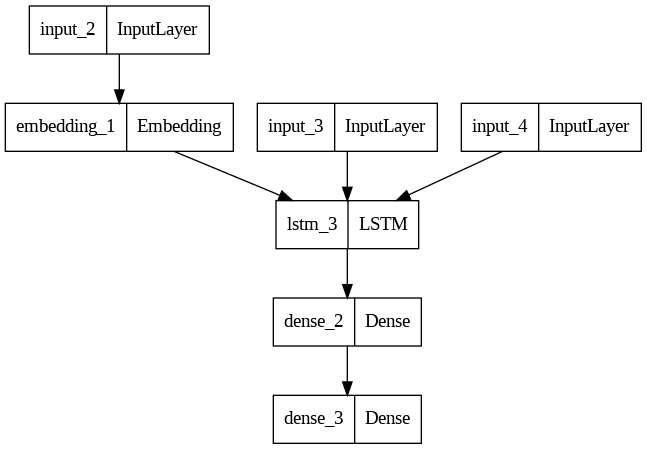

In [23]:
plot_model(gen_decoder)

In [24]:
def generate_from_input(encoder_input):
    h,c = gen_encoder.predict(encoder_input)

    decoder_seq = np.zeros((1,1))
    decoder_seq[0,0] = a_tok.word_index['sos']

    generated_sent = ''
    stop_condition= False

    while not stop_condition:
        output,h_state,c_state = gen_decoder.predict([decoder_seq]+[h,c])
        sampled_index = np.argmax(output[0,-1,:])
        sampled_word = a_tok.index_word[sampled_index]

        if sampled_word != 'eos':
            generated_sent = generated_sent + sampled_word + ' '

        if sampled_word == 'eos' or len(generated_sent) >= answer_sequence_size:
            stop_condition=True

        decoder_seq = np.zeros((1,1))
        decoder_seq[0,0] = sampled_index
        h,c = h_state,c_state

    return generated_sent.strip()

print(generate_from_input(train_encoder_input[0].reshape(1,question_sequence_size,-1)))
print(generate_from_input(train_encoder_input[100].reshape(1,question_sequence_size,-1)))
print(generate_from_input(train_encoder_input[2050].reshape(1,question_sequence_size,-1)))

1/1 [==============================] - 0s 21ms/step
i am not sure eo eo eo
1/1 [==============================] - 0s 21ms/step
i am not sure eo eo eo
1/1 [==============================] - 0s 21ms/step
i am not sure eo eo eo


In [25]:
def seq2question(encoder_input):
    ret=[q_tok.index_word[idx] for idx in encoder_input if idx != 0]
    return ' '.join(ret)

def seq2answer(decoder_input):
    ret = []
    for idx in decoder_input:
        if idx != 0:
            if a_tok.index_word[idx] != 'sos' and a_tok.index_word[idx] != 'eos':
                ret.append(a_tok.index_word[idx])

    return ' '.join(ret)

In [27]:
#results on train dataset
sample_indices= [5,26,7,11,735,662,115,321]

for idx in sample_indices:
    generated_sent = generate_from_input(train_encoder_input[idx:idx+1].reshape(1,question_sequence_size,-1))
    print(f"Question >> {seq2question(train_encoder_input[idx])}")
    print(f"Answer(Generated) >> {generated_sent}")
    print(f"Answer(Label) >> {seq2answer(train_decoder_input[idx])}")
    print("="*45)
    print("\n")


1/1 [==============================] - 0s 70ms/step
Question >> these are chucks
Answer(Generated) >> i am glad to have to
Answer(Label) >> your shoes look really nice how much did you get them for


1/1 [==============================] - 0s 22ms/step
Question >> i would not do that
Answer(Generated) >> i am not sure eo eo eo
Answer(Label) >> why not


1/1 [==============================] - 0s 23ms/step
Question >> then why is there mud on the carpet
Answer(Generated) >> i am not sure eo eo eo
Answer(Label) >> i do not know it is not my mud


1/1 [==============================] - 0s 22ms/step
Question >> considering that it is over ninety degrees outside that would be weird
Answer(Generated) >> i am glad to have to
Answer(Label) >> exactly it would not be nice if it started raining it is too hot


1/1 [==============================] - 0s 20ms/step
Question >> what kind of change
Answer(Generated) >> i am not sure eo eo eo
Answer(Label) >> they want tax cuts


1/1 [===================

In [29]:
#results on test dataset
sample_indices= [159,29,44,33]

for idx in sample_indices:
    generated_sent = generate_from_input(test_encoder_input[idx:idx+1].reshape(1,question_sequence_size,-1))
    print(f"Question >> {seq2question(test_encoder_input[idx])}")
    print(f"Answer(Generated) >> {generated_sent}")
    print(f"Answer(Label) >> {seq2answer(test_decoder_input[idx])}")
    print("="*45)
    print("\n")


1/1 [==============================] - 0s 64ms/step
Question >> it is no problem i was really missing you anyway
Answer(Generated) >> i am not sure eo eo eo
Answer(Label) >> i missed you too


1/1 [==============================] - 0s 35ms/step
Question >> you do not need a job i make enough money for both of us
Answer(Generated) >> i am not sure eo eo eo
Answer(Label) >> that does not matter i do not want to sit around


1/1 [==============================] - 0s 22ms/step
Question >> please
Answer(Generated) >> i am not happy eo eo
Answer(Label) >> you know the rules


1/1 [==============================] - 0s 50ms/step
Question >> that is no good
Answer(Generated) >> i am not sure eo eo eo
Answer(Label) >> we have to find a cheaper house




# With Attention


In [30]:
import tensorflow
from tensorflow.keras.layers import Attention

In [31]:
#trainer model

hidden_size = 256

#encoder part start
encoder_input = Input(shape=[question_sequence_size])
# encoder_embedding = Embedding(question_vocab_size,embedding_size,mask_zero=True,trainable=False,weights=[question_embedding_matrix])
encoder_embedding = Embedding(question_vocab_size,embedding_size,mask_zero=True)
encoder_embedded = encoder_embedding(encoder_input)

lstm1 = LSTM(hidden_size,return_sequences=True,return_state=True,dropout=0.3,recurrent_dropout=0.3)
encoder_output1,_,_= lstm1(encoder_embedded)
lstm2 = LSTM(hidden_size,return_sequences=True,return_state=True,dropout=0.3,recurrent_dropout=0.3)
encoder_output2,_,_ = lstm2(encoder_output1)
lstm3 = LSTM(hidden_size,return_sequences=True,return_state=True,dropout=0.3,recurrent_dropout=0.3)
encoder_output3,encoder_h3,encoder_c3= lstm3(encoder_output2)
#encoder part done

#decoder part start
decoder_input = Input(shape=(None,))
# decoder_embedding = Embedding(answer_vocab_size,embedding_size,mask_zero=True,trainable=False,weights=[answer_embedding_matrix])
decoder_embedding = Embedding(answer_vocab_size,embedding_size,mask_zero=True)
decoder_embedded = decoder_embedding(decoder_input)

decoder_lstm = LSTM(hidden_size,return_sequences=True,return_state=True)
decoder_output,_,_ = decoder_lstm(decoder_embedded,initial_state=[encoder_h3,encoder_c3])

#Attention layer (query,value)
attn_layer = Attention()
attention_context = attn_layer([decoder_output,encoder_output3])

decoder_output = Concatenate(axis=-1)([decoder_output,attention_context])

dense1 = Dense(512,activation='relu')
decoder_output = dense1(decoder_output)

decoder_softmax = Dense(answer_vocab_size,activation='softmax')
decoder_output = decoder_softmax(decoder_output)

trainer = Model([encoder_input,decoder_input],decoder_output)
loss = tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
trainer.compile(loss=loss,optimizer='adam',metrics=['accuracy'])

In [32]:
train_hist = trainer.fit([train_encoder_input,train_decoder_input],train_decoder_label,epochs=10,validation_split=0.1,batch_size=32)

Epoch 1/10
89/89 [==============================] - 113s 541ms/step - loss: 5.7708 - accuracy: 0.1452 - val_loss: 5.2449 - val_accuracy: 0.1637
Epoch 2/10
89/89 [==============================] - 39s 431ms/step - loss: 5.0869 - accuracy: 0.1628 - val_loss: 5.1390 - val_accuracy: 0.1709
Epoch 3/10
89/89 [==============================] - 38s 424ms/step - loss: 4.8205 - accuracy: 0.1822 - val_loss: 4.9352 - val_accuracy: 0.1961
Epoch 4/10
89/89 [==============================] - 41s 465ms/step - loss: 4.5401 - accuracy: 0.2067 - val_loss: 4.8421 - val_accuracy: 0.2102
Epoch 5/10
89/89 [==============================] - 31s 353ms/step - loss: 4.3112 - accuracy: 0.2221 - val_loss: 4.7332 - val_accuracy: 0.2282
Epoch 6/10
89/89 [==============================] - 36s 410ms/step - loss: 4.0978 - accuracy: 0.2417 - val_loss: 4.7139 - val_accuracy: 0.2294
Epoch 7/10
89/89 [==============================] - 37s 412ms/step - loss: 3.9018 - accuracy: 0.2538 - val_loss: 4.7522 - val_accuracy: 0.237

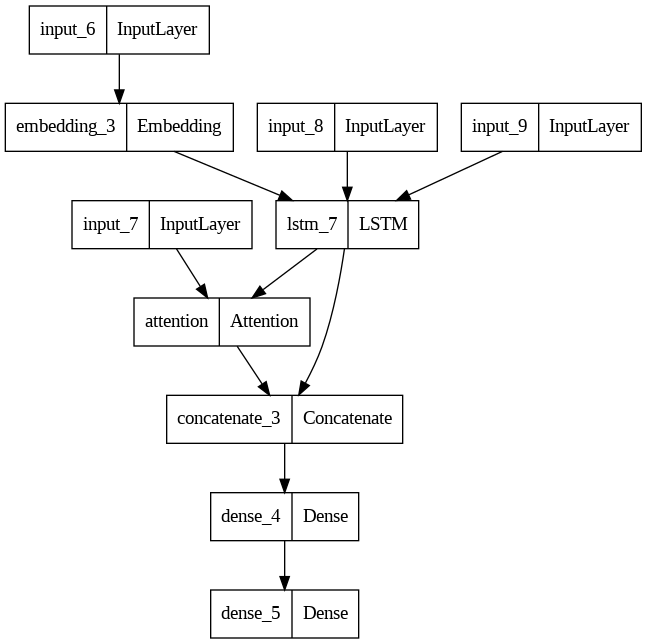

In [33]:
#generator model
gen_encoder = Model(encoder_input,[encoder_output3,encoder_h3,encoder_c3])

gen_decoder_value_input = Input(shape=(question_sequence_size,hidden_size))
gen_decoder_h_input = Input(shape=[hidden_size])
gen_decoder_c_input = Input(shape=[hidden_size])

gen_decoder_embedded = decoder_embedding(decoder_input)
gen_decoder_output,gen_decoder_h,gen_decoder_c = decoder_lstm(gen_decoder_embedded,initial_state=[gen_decoder_h_input,gen_decoder_c_input])

#attention([querys,values])
gen_attention_context = attn_layer([gen_decoder_output,gen_decoder_value_input])
gen_decoder_output = Concatenate(axis=-1)([gen_decoder_output,gen_attention_context])

gen_decoder_output = dense1(gen_decoder_output)
gen_decoder_output = decoder_softmax(gen_decoder_output)

gen_decoder = Model([decoder_input]+[gen_decoder_value_input,gen_decoder_h_input,gen_decoder_c_input],[gen_decoder_output]+[gen_decoder_h,gen_decoder_c])

plot_model(gen_encoder)
plot_model(gen_decoder)

In [34]:
def generate_from_input(encoder_input):
    values,h,c = gen_encoder.predict(encoder_input)

    decoder_seq = np.zeros((1,1))
    decoder_seq[0,0] = a_tok.word_index['sos']

    generated_sent = ''
    stop_condition= False

    while not stop_condition:
        output,h_state,c_state = gen_decoder.predict([decoder_seq]+[values,h,c])
        sampled_index = np.argmax(output[0,-1,:])
        sampled_word = a_tok.index_word[sampled_index]

        if sampled_word != 'eos':
            generated_sent = generated_sent + sampled_word + ' '

        if sampled_word == 'eos' or len(generated_sent) >= answer_sequence_size:
            stop_condition=True

        decoder_seq = np.zeros((1,1))
        decoder_seq[0,0] = sampled_index
        h,c = h_state,c_state

    return generated_sent.strip()

print(generate_from_input(train_encoder_input[24].reshape(1,question_sequence_size,-1)))
print(generate_from_input(train_encoder_input[1021].reshape(1,question_sequence_size,-1)))
print(generate_from_input(train_encoder_input[3001].reshape(1,question_sequence_size,-1)))

1/1 [==============================] - 0s 35ms/step
i will have been a good
1/1 [==============================] - 0s 37ms/step
i am going to do that
1/1 [==============================] - 0s 37ms/step
i have been a good restaurant


In [36]:
#results on train dataset
sample_indices= [5,26,7,11,735,662,115,321]

for idx in sample_indices:
    generated_sent = generate_from_input(train_encoder_input[idx:idx+1].reshape(1,question_sequence_size,-1))
    print(f"Question >> {seq2question(train_encoder_input[idx])}")
    print(f"Answer(Generated) >> {generated_sent}")
    print(f"Answer(Label) >> {seq2answer(train_decoder_input[idx])}")
    print("="*45)
    print("\n")

1/1 [==============================] - 0s 42ms/step
Question >> these are chucks
Answer(Generated) >> i am going to be buried
Answer(Label) >> your shoes look really nice how much did you get them for


1/1 [==============================] - 0s 34ms/step
Question >> i would not do that
Answer(Generated) >> i am going to be buried
Answer(Label) >> why not


1/1 [==============================] - 0s 40ms/step
Question >> then why is there mud on the carpet
Answer(Generated) >> i am going to be a teacher
Answer(Label) >> i do not know it is not my mud


1/1 [==============================] - 0s 40ms/step
Question >> considering that it is over ninety degrees outside that would be weird
Answer(Generated) >> i have not sure i am
Answer(Label) >> exactly it would not be nice if it started raining it is too hot


1/1 [==============================] - 0s 37ms/step
Question >> what kind of change
Answer(Generated) >> i am going to go to the
Answer(Label) >> they want tax cuts


1/1 [==========

In [38]:
#results on test dataset
sample_indices= [159,29,44,33]

for idx in sample_indices:
    generated_sent = generate_from_input(test_encoder_input[idx:idx+1].reshape(1,question_sequence_size,-1))
    print(f"Question >> {seq2question(test_encoder_input[idx])}")
    print(f"Answer(Generated) >> {generated_sent}")
    print(f"Answer(Label) >> {seq2answer(test_decoder_input[idx])}")
    print("="*45)
    print("\n")

1/1 [==============================] - 0s 75ms/step
Question >> it is no problem i was really missing you anyway
Answer(Generated) >> i am going to be a teacher
Answer(Label) >> i missed you too


1/1 [==============================] - 0s 73ms/step
Question >> you do not need a job i make enough money for both of us
Answer(Generated) >> i have not sure i am
Answer(Label) >> that does not matter i do not want to sit around


1/1 [==============================] - 0s 70ms/step
Question >> please
Answer(Generated) >> i am not sure eo eo eo
Answer(Label) >> you know the rules


1/1 [==============================] - 0s 22ms/step
Question >> that is no good
Answer(Generated) >> i am going to be buried
Answer(Label) >> we have to find a cheaper house


